# RIC and RBDS debugg joint angle calculation

Reginaldo K Fukuchi 

### Debugg angles
Try to find the source of difference in the outputs of RIC and RBDS angles. So far the only direction that seems consistent is the Z-axis.

Start by checking the foot markers and reference frame.

RBDS Lab Coordinate system
*       X - points to the driection of walking
*       Y - points vertically upwards
*       Z - points to the subject's right

RIC the following Lab Coordinate system
*       X - points to the subject's right
*       Y - points vertically upwards
*       Z - points opposite of the walking direction

%% NOTE the Segment coordinate systems
*       X - Anterior .....................................[AB / AD duction]
*       Y - Vertically upwards ............................[Axial rotation]
*       Z - points to the subject's right side ...[Hinge flexion extension]

This NB implements the "gait_steps.m" Sean Osis method to detect gait events.
# <font color='red'>PENDING-TO DO!!</font>
* filter markers RBDS
* Batch process

In [1]:
# Prepare environment
import os, glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(1, r'../functions')

In [2]:
#from ezc3d import c3d
import parse_gait_kinematics as parse_gait
import SCS_RIC as scs
import jointangles3d as jang3d
from gait_kinematics import gait_kinematics
from gait_steps import gait_steps
from svdt import svdt

### RIC data

sub_id = '101679'
trial = '20160226T120637'

figshare_dir = r'C:\Users\Reginaldo\OneDrive - University of Calgary\data\Figshare_SciData\new_unzip'
# This subject and trial is the best match for speed of 3.5 m/s and age
fn_json=os.path.join(figshare_dir, sub_id, trial+'.json')
neutral, joints, gait, hz = parse_gait.parse_RIC(fn_json)

## RBDS

In [3]:
data_dir = r'C:\Users\Reginaldo\Documents\data\CNPq\RBDS_v2\Figshare'
fn_static = os.path.join(data_dir,'RBDS001static.c3d')
fn_gait = os.path.join(data_dir,'RBDS001runT35.c3d')
neutral, joints, gait, hz = parse_gait.parse_RBDS(fn_static, fn_gait)

#### Reproduce method to calculate 3D angles
Provide same output as gait_kinematics.m Matlab function written by Sean Osis.

In [4]:
# JOINT CENTRES
# Thigh markers
R_lat_knee = joints[['R_lat_knee_X','R_lat_knee_Y','R_lat_knee_Z']].values.flatten()
R_med_knee = joints[['R_med_knee_X','R_med_knee_Y','R_med_knee_Z']].values.flatten()
L_lat_knee = joints[['L_lat_knee_X','L_lat_knee_Y','L_lat_knee_Z']].values.flatten()
L_med_knee = joints[['L_med_knee_X','L_med_knee_Y','L_med_knee_Z']].values.flatten()
L_hip = joints[['L_hip_X','L_hip_Y','L_hip_Z']].values.flatten()
R_hip = joints[['R_hip_X','R_hip_Y','R_hip_Z']].values.flatten()
# Shank markers
R_lat_ankle = joints[['R_lat_ankle_X','R_lat_ankle_Y','R_lat_ankle_Z']].values.flatten()
R_med_ankle = joints[['R_med_ankle_X','R_med_ankle_Y','R_med_ankle_Z']].values.flatten()
L_lat_ankle = joints[['L_lat_ankle_X','L_lat_ankle_Y','L_lat_ankle_Z']].values.flatten()
L_med_ankle = joints[['L_med_ankle_X','L_med_ankle_Y','L_med_ankle_Z']].values.flatten()
# Pelvis markers
pelvis_1 = neutral[['pelvis_1_X','pelvis_1_Y','pelvis_1_Z']].values.flatten()
pelvis_2 = neutral[['pelvis_2_X','pelvis_2_Y','pelvis_2_Z']].values.flatten()
pelvis_3 = neutral[['pelvis_3_X','pelvis_3_Y','pelvis_3_Z']].values.flatten()
pelvis_4 = neutral[['pelvis_4_X','pelvis_4_Y','pelvis_4_Z']].values.flatten()

# the pelvis_jc is simply the average location of the pelvis markers
jcPelvis = (pelvis_1+pelvis_2+pelvis_3+pelvis_4)/4

# HJC
jcL_hip = L_hip + (R_hip-L_hip)/4
jcR_hip = R_hip + (L_hip-R_hip)/4
# midpoint of the two knee markers
jcL_knee = (L_lat_knee+L_med_knee)/2
jcR_knee = (R_lat_knee+R_med_knee)/2
# midpoint of the two ankle markers
jcL_ankle = (L_lat_ankle+L_med_ankle)/2
jcR_ankle = (R_med_ankle+R_lat_ankle)/2

In [5]:
## LEFT FOOT
#% long axis of the the foot is aligned with the lab
l_foot_x = np.array([0, 0, -1])

#% vertical axis of the foot is aligned with the two markers on the heel
#% FIRST need to identify the heel markers
#% Combine 3 feet markers into one matrix ... can ignore the created fourth one
L_foot = neutral[['L_foot_1_X','L_foot_1_Y','L_foot_1_Z',
                 'L_foot_2_X','L_foot_2_Y','L_foot_2_Z',
                 'L_foot_3_X','L_foot_3_Y','L_foot_3_Z']].values.reshape((3,3))

# sort the markers from left to right
L_foot = L_foot[L_foot[:, 0].argsort()]
# SECOND, create a vector from the two left markers (not the lateral one)
l_foot_temp = (L_foot[1,:]-L_foot[2,:])/np.linalg.norm(L_foot[1,:]-L_foot[2,:])

#% check that it is pointing up ... and if not, flip it
if l_foot_temp[1] < 0:
    l_foot_temp = -l_foot_temp
    
#% use the temp vertical axis to create the lateral axis
l_foot_z = np.cross(l_foot_x,l_foot_temp)/np.linalg.norm(np.cross(l_foot_x,
                                                                  l_foot_temp))

#% and create the 'vertical' axis that provides standing eversion angle
l_foot_y = np.cross(l_foot_z,l_foot_x)/np.linalg.norm(np.cross(l_foot_z, 
                                                               l_foot_x))

#% combine to create a transformation matrix from anatomical to global
agL_foot = np.array([l_foot_x,l_foot_y,l_foot_z]).T
print('Versors of the Left foot segment from anatomical to global')
print(agL_foot)

Versors of the Left foot segment from anatomical to global
[[ 0.          0.07830402  0.99692953]
 [ 0.          0.99692953 -0.07830402]
 [-1.          0.          0.        ]]


In [6]:
#%% RIGHT FOOT
#% long axis of the the foot is aligned with the lab
r_foot_x = np.array([0, 0, -1])

#% vertical axis of the foot is aligned with the two markers on the heel
#% FIRST need to identify the heel markers
#% Combine 3 feet markers into one matrix ... can ignore the created fourth one
R_foot = neutral[['R_foot_1_X','R_foot_1_Y','R_foot_1_Z',
                 'R_foot_2_X','R_foot_2_Y','R_foot_2_Z',
                 'R_foot_3_X','R_foot_3_Y','R_foot_3_Z']].values.reshape((3,3))

# sort the markers from left to right
R_foot = R_foot[R_foot[:, 0].argsort()]
# SECOND, create a vector from the two left markers (not the lateral one)
r_foot_temp = (R_foot[0,:]-R_foot[1,:])/np.linalg.norm(R_foot[0,:]-R_foot[1,:])

#% check that it is pointing up ... and if not, flip it
if r_foot_temp[1] < 0:
    r_foot_temp = -r_foot_temp
    
#% use the temp vertical axis to create the lateral axis
r_foot_z = np.cross(r_foot_x,r_foot_temp)/np.linalg.norm(np.cross(r_foot_x,
                                                                  r_foot_temp))

#% and create the 'vertical' axis that provides standing eversion angle
r_foot_y = np.cross(r_foot_z,r_foot_x)/np.linalg.norm(np.cross(r_foot_z, 
                                                               r_foot_x))

#% combine to create a transformation matrix from anatomical to global
agR_foot = np.array([r_foot_x,r_foot_y,r_foot_z]).T
print('Versors of the foot segment from anatomical to global')
print(agR_foot)

Versors of the foot segment from anatomical to global
[[ 0.         -0.00964463  0.99995349]
 [ 0.          0.99995349  0.00964463]
 [-1.          0.          0.        ]]


In [7]:
#%% LEFT SHANK
l_shank_y=(jcL_knee-jcL_ankle)/np.linalg.norm(jcL_knee-jcL_ankle); #long axis pointing up
l_shank_temp=(L_med_ankle-L_lat_ankle)/np.linalg.norm(L_med_ankle-L_lat_ankle) #almost the hinge joing pointing to the right
l_shank_x= np.cross(l_shank_y,l_shank_temp)/np.linalg.norm(np.cross(l_shank_y,l_shank_temp)) #Anterior axis from the cross
l_shank_z=np.cross(l_shank_x,l_shank_y)/np.linalg.norm(np.cross(l_shank_x,l_shank_y)) #hinge axis, lateral for right

# combine to create a transformation matrix from anatomical to global
agL_shank=np.array([l_shank_x,l_shank_y,l_shank_z]).T
print('Versors of the shank segment from anatomical to global')
print(agL_shank)

Versors of the shank segment from anatomical to global
[[-0.24709284  0.03976932  0.96817536]
 [-0.05116857  0.99722788 -0.05402168]
 [-0.96763986 -0.06288852 -0.24437293]]


In [8]:
#%% RIGHT SHANK
r_shank_y=(jcR_knee-jcR_ankle)/np.linalg.norm(jcR_knee-jcR_ankle); #long axis pointing up
r_shank_temp=(R_lat_ankle-R_med_ankle)/np.linalg.norm(R_lat_ankle-R_med_ankle) #almost the hinge joing pointing to the right
r_shank_x= np.cross(r_shank_y,r_shank_temp)/np.linalg.norm(np.cross(r_shank_y,r_shank_temp)) #Anterior axis from the cross
r_shank_z=np.cross(r_shank_x,r_shank_y)/np.linalg.norm(np.cross(r_shank_x,r_shank_y)) #hinge axis, lateral for right

# combine to create a transformation matrix from anatomical to global
agR_shank=np.array([r_shank_x,r_shank_y,r_shank_z]).T
print('Versors of the shank segment from anatomical to global')
print(agR_shank)

Versors of the shank segment from anatomical to global
[[ 0.21148426 -0.06263446  0.97537241]
 [-0.03645553  0.99674458  0.07191133]
 [-0.97670129 -0.05076583  0.20851241]]


In [9]:
# LEFT THIGH
l_thigh_y=(jcL_hip-jcL_knee)/np.linalg.norm(jcL_hip-jcL_knee)#long axis pointing up
#almost the hinge joing pointing to the right from the knee joint markers
l_thigh_temp=(L_med_knee-L_lat_knee)/np.linalg.norm(L_med_knee-L_lat_knee)
l_thigh_x=np.cross(l_thigh_y,l_thigh_temp)/np.linalg.norm(np.cross(l_thigh_y,l_thigh_temp))
l_thigh_z=np.cross(l_thigh_x,l_thigh_y)/np.linalg.norm(np.cross(l_thigh_x,l_thigh_y))

# combine to create a transformation matrix from anatomical to global
agL_thigh=np.array([l_thigh_x,l_thigh_y,l_thigh_z]).T
print('Versors of the thigh segment from anatomical to global')
print(agL_thigh)

Versors of the thigh segment from anatomical to global
[[ 0.16332679  0.07439779  0.98376284]
 [-0.12573154  0.99059137 -0.05403994]
 [-0.97852743 -0.11486385  0.17114426]]


In [10]:
# RIGHT THIGH
r_thigh_y=(jcR_hip-jcR_knee)/np.linalg.norm(jcR_hip-jcR_knee)#long axis pointing up
#almost the hinge joing pointing to the right from the knee joint markers
r_thigh_temp=(R_lat_knee-R_med_knee)/np.linalg.norm(R_lat_knee-R_med_knee)
r_thigh_x=np.cross(r_thigh_y,r_thigh_temp)/np.linalg.norm(np.cross(r_thigh_y,r_thigh_temp))
r_thigh_z=np.cross(r_thigh_x,r_thigh_y)/np.linalg.norm(np.cross(r_thigh_x,r_thigh_y))

# combine to create a transformation matrix from anatomical to global
agR_thigh=np.array([r_thigh_x,r_thigh_y,r_thigh_z]).T
print('Versors of the thigh segment from anatomical to global')
print(agR_thigh)

Versors of the thigh segment from anatomical to global
[[-0.01916483 -0.06164276  0.99791426]
 [-0.0944786   0.99374299  0.05957065]
 [-0.99534241 -0.09313988 -0.02486884]]


In [11]:
## PELVIS
# since trochanters are hard to landmark, pelvis will just be orthogonal to the lab
pelvis_x=np.array([0,0,-1])#anterior axis
pelvis_y=np.array([0,1,0])#long axis pointing up
pelvis_z=np.array([1,0,0])#hinge axis to the subject's right
# combine to create a transformation matrix from anatomical to global
ag_Pelvis=np.array([pelvis_x,pelvis_y,pelvis_z]).T

print('Versors of the pelvis segment from anatomical to global')
print(ag_Pelvis)

Versors of the pelvis segment from anatomical to global
[[ 0  0  1]
 [ 0  1  0]
 [-1  0  0]]


In [12]:
# %% use the transformation matrixes we just made to get the segment markers
# % in terms of the ANATOMICAL COORDINATE system (ie if the anatomical
# % coordinate system was located at the world orgin, where would the markers
# % be located). this can be better understood by visualizing the vectors
# % defining the marker location.
# % the marker locations in this reference frame will be used with the
# % soderkvist method as 'before' inputs.

# Rename foot markers in the neutral standing trial
L_foot_1_S = neutral[['L_foot_1_X','L_foot_1_Y','L_foot_1_Z']].values
L_foot_2_S = neutral[['L_foot_2_X','L_foot_2_Y','L_foot_2_Z']].values
L_foot_3_S = neutral[['L_foot_3_X','L_foot_3_Y','L_foot_3_Z']].values
L_foot_4_S = neutral[['L_foot_4_X','L_foot_4_Y','L_foot_4_Z']].values

# % the foot markers in an ANATOMICAL COORDINATE system ...
acL_foot_1=np.dot(agL_foot.T, L_foot_1_S.T)
acL_foot_2=np.dot(agL_foot.T, L_foot_2_S.T)
acL_foot_3=np.dot(agL_foot.T, L_foot_3_S.T)
acL_foot_4=np.dot(agL_foot.T, L_foot_4_S.T)
acL_foot=np.array([acL_foot_1, acL_foot_2, acL_foot_3, acL_foot_4]).T[0,:,:]

# Centroid of markers
centroid = np.mean(acL_foot, axis=1)
# Ankle joint centre in the Foot CS
djcL_ankle=np.dot(agL_foot.T, jcL_ankle.T) - centroid

print('foot markers in an ANATOMICAL COORDINATE system')
print(acL_foot)
print('Ankle joint centre in the Foot CS')
print(djcL_ankle)

foot markers in an ANATOMICAL COORDINATE system
[[ 641.82810465  633.31400594  663.43439046  646.19216702]
 [ 175.52131619  127.87551392  142.17363157  148.52348723]
 [1078.4280858  1078.4280858  1038.86090036 1065.23902399]]
Ankle joint centre in the Foot CS
[69.14220879 50.52513582 12.49680244]


In [13]:
# Rename foot markers in the neutral standing trial
R_foot_1_S = neutral[['R_foot_1_X','R_foot_1_Y','R_foot_1_Z']].values
R_foot_2_S = neutral[['R_foot_2_X','R_foot_2_Y','R_foot_2_Z']].values
R_foot_3_S = neutral[['R_foot_3_X','R_foot_3_Y','R_foot_3_Z']].values
R_foot_4_S = neutral[['R_foot_4_X','R_foot_4_Y','R_foot_4_Z']].values

# % the foot markers in an ANATOMICAL COORDINATE system ...
acR_foot_1=np.dot(agR_foot.T, R_foot_1_S.T)
acR_foot_2=np.dot(agR_foot.T, R_foot_2_S.T)
acR_foot_3=np.dot(agR_foot.T, R_foot_3_S.T)
acR_foot_4=np.dot(agR_foot.T, R_foot_4_S.T)
acR_foot=np.array([acR_foot_1, acR_foot_2, acR_foot_3, acR_foot_4]).T[0,:,:]

# Centroid of markers
centroid = np.mean(acR_foot, axis=1)
# Ankle joint centre in the Foot CS
djcR_ankle=np.dot(agR_foot.T, jcR_ankle.T) - centroid

print('foot markers in an ANATOMICAL COORDINATE system')
print(acR_foot)
print('Ankle joint centre in the Foot CS')
print(djcR_ankle)

foot markers in an ANATOMICAL COORDINATE system
[[ 638.93188558  627.51655965  658.38056478  641.60967   ]
 [  77.62639227   29.45548127   45.40210703   50.82799352]
 [1360.44516176 1360.44516176 1403.79755619 1374.8959599 ]]
Ankle joint centre in the Foot CS
[ 69.35312561  49.68143854 -17.76965345]


In [14]:
# Rename LEFT shank markers in the neutral standing trial
L_shank_1_S = neutral[['L_shank_1_X','L_shank_1_Y','L_shank_1_Z']].values
L_shank_2_S = neutral[['L_shank_2_X','L_shank_2_Y','L_shank_2_Z']].values
L_shank_3_S = neutral[['L_shank_3_X','L_shank_3_Y','L_shank_3_Z']].values
L_shank_4_S = neutral[['L_shank_4_X','L_shank_4_Y','L_shank_4_Z']].values

# % the shank markers in an ANATOMICAL COORDINATE system ...
acL_shank_1=np.dot(agL_shank.T, L_shank_1_S.T)
acL_shank_2=np.dot(agL_shank.T, L_shank_2_S.T)
acL_shank_3=np.dot(agL_shank.T, L_shank_3_S.T)
acL_shank_4=np.dot(agL_shank.T, L_shank_4_S.T)
acL_shank=np.array([acL_shank_1, acL_shank_2, acL_shank_3, acL_shank_4]).T[0,:,:]
# Centroid of markers
centroid = np.mean(acL_shank, axis=1)
# Knee joint centre in the Foot CS
djcL_knee=np.dot(agL_shank.T, jcL_knee.T) - centroid

print('shank markers in an ANATOMICAL COORDINATE system')
print(acL_shank)
print('knee joint centre in the Foot CS')
print(djcL_knee)

shank markers in an ANATOMICAL COORDINATE system
[[ 422.74005543  374.22299789  417.30134     367.33993835]
 [ 277.48118148  275.02332208  356.30766289  358.20170254]
 [1174.36226473 1191.3824691  1157.20725355 1177.29460757]]
knee joint centre in the Foot CS
[ 21.61497617 317.67730899  48.90943528]


In [15]:
# Rename RIGHT shank markers in the neutral standing trial
R_shank_1_S = neutral[['R_shank_1_X','R_shank_1_Y','R_shank_1_Z']].values
R_shank_2_S = neutral[['R_shank_2_X','R_shank_2_Y','R_shank_2_Z']].values
R_shank_3_S = neutral[['R_shank_3_X','R_shank_3_Y','R_shank_3_Z']].values
R_shank_4_S = neutral[['R_shank_4_X','R_shank_4_Y','R_shank_4_Z']].values

# % the shank markers in an ANATOMICAL COORDINATE system ...
acR_shank_1=np.dot(agR_shank.T, R_shank_1_S.T)
acR_shank_2=np.dot(agR_shank.T, R_shank_2_S.T)
acR_shank_3=np.dot(agR_shank.T, R_shank_3_S.T)
acR_shank_4=np.dot(agR_shank.T, R_shank_4_S.T)
acR_shank=np.array([acR_shank_1, acR_shank_2, acR_shank_3, acR_shank_4]).T[0,:,:]
# Centroid of markers
centroid = np.mean(acR_shank, axis=1)
# Knee joint centre in the Foot CS
djcR_knee=np.dot(agR_shank.T, jcR_knee.T) - centroid

print('shank markers in an ANATOMICAL COORDINATE system')
print(acR_shank)
print('knee joint centre in the Foot CS')
print(djcR_knee)

shank markers in an ANATOMICAL COORDINATE system
[[ 975.14547968  926.99666615  970.74567625  924.04814348]
 [ 137.81560694  141.70533746  217.48342278  220.40987403]
 [1233.54742708 1207.41665383 1249.82713718 1222.1990125 ]]
knee joint centre in the Foot CS
[ 27.81565518 319.51541346 -45.62696408]


In [16]:
# Rename LEFT thigh markers in the neutral standing trial
L_thigh_1_S = neutral[['L_thigh_1_X','L_thigh_1_Y','L_thigh_1_Z']].values
L_thigh_2_S = neutral[['L_thigh_2_X','L_thigh_2_Y','L_thigh_2_Z']].values
L_thigh_3_S = neutral[['L_thigh_3_X','L_thigh_3_Y','L_thigh_3_Z']].values
L_thigh_4_S = neutral[['L_thigh_4_X','L_thigh_4_Y','L_thigh_4_Z']].values

# % the thigh markers in an ANATOMICAL COORDINATE system ...
acL_thigh_1=np.dot(agL_thigh.T, L_thigh_1_S.T)
acL_thigh_2=np.dot(agL_thigh.T, L_thigh_2_S.T)
acL_thigh_3=np.dot(agL_thigh.T, L_thigh_3_S.T)
acL_thigh_4=np.dot(agL_thigh.T, L_thigh_4_S.T)
acL_thigh=np.array([acL_thigh_1, acL_thigh_2, acL_thigh_3, acL_thigh_4]).T[0,:,:]

# Centroid of markers
centroid = np.mean(acL_thigh, axis=1)
# Knee joint centre in the Foot CS
djcL_hip=np.dot(agL_thigh.T, jcL_hip.T) - centroid

print('thigh markers in an ANATOMICAL COORDINATE system')
print(acL_thigh)
print('hip joint centre in the Foot CS')
print(djcL_hip)

thigh markers in an ANATOMICAL COORDINATE system
[[813.12536569 769.06312467 796.71586918 761.11005534]
 [832.22266091 832.59731837 941.43563344 942.87591735]
 [862.45239554 921.16941922 853.95721415 913.52321787]]
hip joint centre in the Foot CS
[ 53.8638952  244.97750932  44.9121734 ]


In [17]:
# Rename thigh markers in the neutral standing trial
R_thigh_1_S = neutral[['R_thigh_1_X','R_thigh_1_Y','R_thigh_1_Z']].values
R_thigh_2_S = neutral[['R_thigh_2_X','R_thigh_2_Y','R_thigh_2_Z']].values
R_thigh_3_S = neutral[['R_thigh_3_X','R_thigh_3_Y','R_thigh_3_Z']].values
R_thigh_4_S = neutral[['R_thigh_4_X','R_thigh_4_Y','R_thigh_4_Z']].values

# % the thigh markers in an ANATOMICAL COORDINATE system ...
acR_thigh_1=np.dot(agR_thigh.T, R_thigh_1_S.T)
acR_thigh_2=np.dot(agR_thigh.T, R_thigh_2_S.T)
acR_thigh_3=np.dot(agR_thigh.T, R_thigh_3_S.T)
acR_thigh_4=np.dot(agR_thigh.T, R_thigh_4_S.T)
acR_thigh=np.array([acR_thigh_1, acR_thigh_2, acR_thigh_3, acR_thigh_4]).T[0,:,:]

# Centroid of markers
centroid = np.mean(acR_thigh, axis=1)
# Knee joint centre in the Foot CS
djcR_hip=np.dot(agR_thigh.T, jcR_hip.T) - centroid

print('thigh markers in an ANATOMICAL COORDINATE system')
print(acR_thigh)
print('hip joint centre in the Foot CS')
print(djcR_hip)

thigh markers in an ANATOMICAL COORDINATE system
[[ 642.76945993  589.8063905   624.45818007  577.16710445]
 [ 629.43273174  626.84887708  738.46098073  735.79378335]
 [1450.72939645 1398.77771549 1459.51819311 1407.65278345]]
hip joint centre in the Foot CS
[ 43.93932028 269.25027665 -52.26665201]


In [18]:
# Rename Pelvic markers in the neutral standing trial
pelvis_1_S = neutral[['pelvis_1_X','pelvis_1_Y','pelvis_1_Z']].values
pelvis_2_S = neutral[['pelvis_2_X','pelvis_2_Y','pelvis_2_Z']].values
pelvis_3_S = neutral[['pelvis_3_X','pelvis_3_Y','pelvis_3_Z']].values
pelvis_4_S = neutral[['pelvis_4_X','pelvis_4_Y','pelvis_4_Z']].values

# % the pelvis markers in an ANATOMICAL COORDINATE system ...
ac_Pelvis_1=np.dot(ag_Pelvis.T, pelvis_1_S.T)
ac_Pelvis_2=np.dot(ag_Pelvis.T, pelvis_2_S.T)
ac_Pelvis_3=np.dot(ag_Pelvis.T, pelvis_3_S.T)
ac_Pelvis_4=np.dot(ag_Pelvis.T, pelvis_4_S.T)
ac_Pelvis=np.array([ac_Pelvis_1, ac_Pelvis_2, ac_Pelvis_3, ac_Pelvis_4]).T[0,:,:]

# Centroid of markers
centroid = np.mean(ac_Pelvis, axis=1)
# Pelvis joint centre in the Foot CS
djcPelvis=np.dot(ag_Pelvis.T, jcPelvis.T) - centroid

print('Pelvic markers in an ANATOMICAL COORDINATE system')
print(ac_Pelvis)
print('Pelvic centroid in the Pelvic CS')
print(djcPelvis)

Pelvic markers in an ANATOMICAL COORDINATE system
[[ 878.46722453  856.8976766   697.03824951  700.75459676]
 [1067.1955957  1060.51998698 1097.83932861 1099.03289714]
 [1126.76440674 1337.26621582 1258.34735758 1181.58725423]]
Pelvic centroid in the Pelvic CS
[0. 0. 0.]


In [19]:
# %% create the rotation matrix from segment to lab for all the segments for
# % every time point. this uses soderkvist. the operations done on the
# % neutral trial data only need to be done once and can be done before we
# % load the dynamic data and are therefore outside of the loop

# % calculate average marker position of the segment markers
avg_ac_L_foot =np.mean(acL_foot,axis=1)
avg_ac_R_foot =np.mean(acR_foot,axis=1)
avg_ac_L_shank=np.mean(acL_shank,axis=1)
avg_ac_R_shank=np.mean(acR_shank,axis=1)
avg_ac_L_thigh=np.mean(acL_thigh,axis=1)
avg_ac_R_thigh=np.mean(acR_thigh,axis=1)
avg_ac_Pelvis =np.mean(ac_Pelvis,axis=1)

# % calculate the distance from the marker posisiton to the average position
# % neutral
dif_ac_L_foot=np.array([acL_foot[0,:]-avg_ac_L_foot[0],
                       acL_foot[1,:]-avg_ac_L_foot[1],
                       acL_foot[2,:]-avg_ac_L_foot[2]])
dif_ac_R_foot=np.array([acR_foot[0,:]-avg_ac_R_foot[0],
                       acR_foot[1,:]-avg_ac_R_foot[1],
                       acR_foot[2,:]-avg_ac_R_foot[2]])
dif_ac_L_shank=np.array([acL_shank[0,:]-avg_ac_L_shank[0],
                       acL_shank[1,:]-avg_ac_L_shank[1],
                       acL_shank[2,:]-avg_ac_L_shank[2]])
dif_ac_R_shank=np.array([acR_shank[0,:]-avg_ac_R_shank[0],
                       acR_shank[1,:]-avg_ac_R_shank[1],
                       acR_shank[2,:]-avg_ac_R_shank[2]])
dif_ac_L_thigh=np.array([acL_thigh[0,:]-avg_ac_L_thigh[0],
                       acL_thigh[1,:]-avg_ac_L_thigh[1],
                       acL_thigh[2,:]-avg_ac_L_thigh[2]])
dif_ac_R_thigh=np.array([acR_thigh[0,:]-avg_ac_R_thigh[0],
                       acR_thigh[1,:]-avg_ac_R_thigh[1],
                       acR_thigh[2,:]-avg_ac_R_thigh[2]])
dif_ac_Pelvis=np.array([ac_Pelvis[0,:]-avg_ac_Pelvis[0],
                       ac_Pelvis[1,:]-avg_ac_Pelvis[1],
                       ac_Pelvis[2,:]-avg_ac_Pelvis[2]])

In [20]:
# %% now we need the DYNAMIC walking/running data from the input argument
# Left Foot marker positions running
L_foot_1_R = gait.filter(like='L_foot_1', axis=1).values
L_foot_2_R = gait.filter(like='L_foot_2', axis=1).values
L_foot_3_R = gait.filter(like='L_foot_3', axis=1).values
L_foot_4_R = gait.filter(like='L_foot_4', axis=1).values
# Right Foot marker positions running
R_foot_1_R = gait.filter(like='R_foot_1', axis=1).values
R_foot_2_R = gait.filter(like='R_foot_2', axis=1).values
R_foot_3_R = gait.filter(like='R_foot_3', axis=1).values
R_foot_4_R = gait.filter(like='R_foot_4', axis=1).values
# left Shank marker positions running
L_shank_1_R = gait.filter(like='L_shank_1', axis=1).values
L_shank_2_R = gait.filter(like='L_shank_2', axis=1).values
L_shank_3_R = gait.filter(like='L_shank_3', axis=1).values
L_shank_4_R = gait.filter(like='L_shank_4', axis=1).values
# Right Shank marker positions running
R_shank_1_R = gait.filter(like='R_shank_1', axis=1).values
R_shank_2_R = gait.filter(like='R_shank_2', axis=1).values
R_shank_3_R = gait.filter(like='R_shank_3', axis=1).values
R_shank_4_R = gait.filter(like='R_shank_4', axis=1).values
# left Thigh marker positions running
L_thigh_1_R = gait.filter(like='L_thigh_1', axis=1).values
L_thigh_2_R = gait.filter(like='L_thigh_2', axis=1).values
L_thigh_3_R = gait.filter(like='L_thigh_3', axis=1).values
L_thigh_4_R = gait.filter(like='L_thigh_4', axis=1).values
# Thigh marker positions running
R_thigh_1_R = gait.filter(like='R_thigh_1', axis=1).values
R_thigh_2_R = gait.filter(like='R_thigh_2', axis=1).values
R_thigh_3_R = gait.filter(like='R_thigh_3', axis=1).values
R_thigh_4_R = gait.filter(like='R_thigh_4', axis=1).values
# Pelvis marker positions running
pelvis_1_R = gait.filter(like='pelvis_1', axis=1).values
pelvis_2_R = gait.filter(like='pelvis_2', axis=1).values
pelvis_3_R = gait.filter(like='pelvis_3', axis=1).values
pelvis_4_R = gait.filter(like='pelvis_4', axis=1).values

# % prealocating the size of these matricies that collect data in the loop
# % to increase speed
# RIGHT SIDE
R_R_foot  =np.zeros(shape=(4,4, R_foot_1_R.shape[0]))
R_R_shank =np.zeros(shape=(4,4, R_foot_1_R.shape[0]))
R_R_thigh =np.zeros(shape=(4,4, R_foot_1_R.shape[0]))
R_R_pelvis=np.zeros(shape=(4,4, R_foot_1_R.shape[0]))
#pre-allaocate angles
R_R_ankle=np.zeros(shape=(4,4, R_foot_1_R.shape[0]))
R_R_knee =np.zeros(shape=(4,4, R_foot_1_R.shape[0]))
R_R_hip  =np.zeros(shape=(4,4, R_foot_1_R.shape[0]))

# LEFT SIDE
R_L_foot  =np.zeros(shape=(4,4, L_foot_1_R.shape[0]))
R_L_shank =np.zeros(shape=(4,4, L_foot_1_R.shape[0]))
R_L_thigh =np.zeros(shape=(4,4, L_foot_1_R.shape[0]))
R_L_pelvis=np.zeros(shape=(4,4, L_foot_1_R.shape[0]))
#pre-allaocate angles
R_L_ankle=np.zeros(shape=(4,4, L_foot_1_R.shape[0]))
R_L_knee =np.zeros(shape=(4,4, L_foot_1_R.shape[0]))
R_L_hip  =np.zeros(shape=(4,4, L_foot_1_R.shape[0]))

In [21]:
# %% need to create matricies from the DYNAMIC data that has the same markers
# % as the " ac.L_foot " in the same order ... matricies for use with soderqvist
dL_foot = np.array([L_foot_1_R.T, L_foot_2_R.T, L_foot_3_R.T, L_foot_4_R.T], ndmin=3)
dL_foot = np.transpose(dL_foot, (1,0,2))
dR_foot = np.array([R_foot_1_R.T, R_foot_2_R.T, R_foot_3_R.T, R_foot_4_R.T], ndmin=3)
dR_foot = np.transpose(dR_foot, (1,0,2))
dL_shank = np.array([L_shank_1_R.T, L_shank_2_R.T, L_shank_3_R.T, L_shank_4_R.T], ndmin=3)
dL_shank = np.transpose(dL_shank, (1,0,2))
dR_shank = np.array([R_shank_1_R.T, R_shank_2_R.T, R_shank_3_R.T, R_shank_4_R.T], ndmin=3)
dR_shank = np.transpose(dR_shank, (1,0,2))
dL_thigh = np.array([L_thigh_1_R.T, L_thigh_2_R.T, L_thigh_3_R.T, L_thigh_4_R.T], ndmin=3)
dL_thigh = np.transpose(dL_thigh, (1,0,2))
dR_thigh = np.array([R_thigh_1_R.T, R_thigh_2_R.T, R_thigh_3_R.T, R_thigh_4_R.T], ndmin=3)
dR_thigh = np.transpose(dR_thigh, (1,0,2))
dPelvis = np.array([pelvis_1_R.T, pelvis_2_R.T, pelvis_3_R.T, pelvis_4_R.T], ndmin=3)
dPelvis = np.transpose(dPelvis, (1,0,2))

# calculate average position of the segment markers
avg_dL_foot = dL_foot.mean(axis=1)
avg_dL_foot = np.repeat(avg_dL_foot[:, np.newaxis,:], 4, axis=1)
avg_dR_foot = dR_foot.mean(axis=1)
avg_dR_foot = np.repeat(avg_dR_foot[:, np.newaxis,:], 4, axis=1)
avg_dL_shank= dL_shank.mean(axis=1)
avg_dL_shank = np.repeat(avg_dL_shank[:, np.newaxis,:], 4, axis=1)
avg_dR_shank= dR_shank.mean(axis=1)
avg_dR_shank = np.repeat(avg_dR_shank[:, np.newaxis,:], 4, axis=1)
avg_dL_thigh= dL_thigh.mean(axis=1)
avg_dL_thigh = np.repeat(avg_dL_thigh[:, np.newaxis,:], 4, axis=1)
avg_dR_thigh= dR_thigh.mean(axis=1)
avg_dR_thigh = np.repeat(avg_dR_thigh[:, np.newaxis,:], 4, axis=1)
avg_dPelvis= dPelvis.mean(axis=1)
avg_dPelvis = np.repeat(avg_dPelvis[:, np.newaxis,:], 4, axis=1)

# calculate the distance from the marker posisiton to the average position
dif_dL_foot = dL_foot - avg_dL_foot
dif_dR_foot = dR_foot - avg_dR_foot
dif_dL_shank= dL_shank - avg_dL_shank
dif_dR_shank= dR_shank - avg_dR_shank
dif_dL_thigh= dL_thigh - avg_dL_thigh
dif_dR_thigh= dR_thigh - avg_dR_thigh
dif_dPelvis= dPelvis - avg_dPelvis

In [22]:
# Repeat array to perform dot product on transposed array
# Uncomment this if you figure out how to do without loop using 
# np.einsum('ijk,ij->ij', dif_dR_foot, dif_ac_R_foot)
# dif_ac_R_footT = dif_ac_R_foot.T # Tranpose array
# dif_ac_R_footT = np.repeat(dif_ac_R_footT[:,:,np.newaxis], 
#                           dif_dR_foot.shape[2], axis=2)

# Preallocate angles
angle_L_ankle = np.empty(shape=(dif_dL_foot.shape[2], 3)) * np.NaN
angle_R_ankle = np.empty(shape=(dif_dR_foot.shape[2], 3)) * np.NaN
angle_L_knee  = np.empty(shape=(dif_dL_foot.shape[2], 3)) * np.NaN
angle_R_knee  = np.empty(shape=(dif_dR_foot.shape[2], 3)) * np.NaN
angle_L_hip  = np.empty(shape=(dif_dL_foot.shape[2], 3)) * np.NaN
angle_R_hip  = np.empty(shape=(dif_dR_foot.shape[2], 3)) * np.NaN
angle_L_foot = np.empty(shape=(dif_dL_foot.shape[2], 3)) * np.NaN
angle_R_foot = np.empty(shape=(dif_dR_foot.shape[2], 3)) * np.NaN
angle_Pelvis = np.empty(shape=(dif_dR_foot.shape[2], 3)) * np.NaN
for i in range(dif_dR_foot.shape[2]):
    # step three of soderkvist
    CL_foot = np.dot(dif_dL_foot[:,:,i], dif_ac_L_foot.T)
    CR_foot = np.dot(dif_dR_foot[:,:,i], dif_ac_R_foot.T)
    CL_shank= np.dot(dif_dL_shank[:,:,i], dif_ac_L_shank.T)
    CR_shank= np.dot(dif_dR_shank[:,:,i], dif_ac_R_shank.T)
    CL_thigh= np.dot(dif_dL_thigh[:,:,i], dif_ac_L_thigh.T)
    CR_thigh= np.dot(dif_dR_thigh[:,:,i], dif_ac_R_thigh.T)
    CPelvis= np.dot(dif_dPelvis[:,:,i], dif_ac_Pelvis.T)
    
    # step four singular value decomposition
    PL_foot, TL_foot, QL_foot = np.linalg.svd(CL_foot)
    TL_foot = np.diag(TL_foot)
    
    PR_foot, TR_foot, QR_foot = np.linalg.svd(CR_foot)
    TR_foot = np.diag(TR_foot)

    PL_shank, TL_shank, QL_shank = np.linalg.svd(CL_shank)
    TL_shank = np.diag(TL_shank)
    
    PR_shank, TR_shank, QR_shank = np.linalg.svd(CR_shank)
    TR_shank = np.diag(TR_shank)

    PL_thigh, TL_thigh, QL_thigh = np.linalg.svd(CL_thigh)
    TL_thigh = np.diag(TL_thigh)
    
    PR_thigh, TR_thigh, QR_thigh = np.linalg.svd(CR_thigh)
    TR_thigh = np.diag(TR_thigh)
    
    PPelvis, TPelvis, QPelvis = np.linalg.svd(CPelvis)
    TPelvis = np.diag(TPelvis)
    
    # step five - calculate a rotation matrix
    # Foot
    R_L_foot = np.dot(PL_foot, np.dot(np.diag([1, 1, 
                                           np.linalg.det(np.dot(PL_foot, 
                                                                QL_foot))]), 
                                  QL_foot))
    
    R_R_foot = np.dot(PR_foot, np.dot(np.diag([1, 1, 
                                               np.linalg.det(np.dot(PR_foot, 
                                                                    QR_foot))]), 
                                      QR_foot))
    # Shank
    R_L_shank = np.dot(PL_shank, np.dot(np.diag([1, 1, 
                                           np.linalg.det(np.dot(PL_shank, 
                                                                QL_shank))]), 
                                  QL_shank))
    
    R_R_shank = np.dot(PR_shank, np.dot(np.diag([1, 1, 
                                               np.linalg.det(np.dot(PR_shank, 
                                                                    QR_shank))]), 
                                      QR_shank))
    
    # Thigh
    R_L_thigh = np.dot(PL_thigh, np.dot(np.diag([1, 1, 
                                               np.linalg.det(np.dot(PL_thigh, 
                                                                    QL_thigh))]), 
                                      QL_thigh))
    
    R_R_thigh = np.dot(PR_thigh, np.dot(np.diag([1, 1, 
                                               np.linalg.det(np.dot(PR_thigh, 
                                                                    QR_thigh))]), 
                                      QR_thigh))
    
    # Pelvis
    R_Pelvis = np.dot(PPelvis, np.dot(np.diag([1, 1, 
                                               np.linalg.det(np.dot(PPelvis, 
                                                                    QPelvis))]), 
                                      QPelvis))
    
    # step six - calculate the displacement
    dis_L_foot = avg_dL_foot[:,0,-1] - np.dot(R_L_foot, avg_ac_L_foot)
    dis_R_foot = avg_dR_foot[:,0,-1] - np.dot(R_R_foot, avg_ac_R_foot)
    dis_L_shank= avg_dL_shank[:,0,-1] - np.dot(R_L_shank, avg_ac_L_shank)
    dis_R_shank= avg_dR_shank[:,0,-1] - np.dot(R_R_shank, avg_ac_R_shank)
    dis_L_thigh= avg_dL_thigh[:,0,-1] - np.dot(R_L_thigh, avg_ac_L_thigh)
    dis_R_thigh= avg_dR_thigh[:,0,-1] - np.dot(R_R_thigh, avg_ac_R_thigh)
    dis_Pelvis= avg_dPelvis[:,0,-1] - np.dot(R_Pelvis, avg_ac_Pelvis)
    
    # combine the rotation matricies in a stack
    RR_L_foot = np.vstack((np.hstack((R_L_foot,dis_L_foot[:,np.newaxis])),
                      np.array([0,0,0,1], ndmin=2)))
    RR_R_foot = np.vstack((np.hstack((R_R_foot,dis_R_foot[:,np.newaxis])),
                      np.array([0,0,0,1], ndmin=2)))
    RR_L_shank = np.vstack((np.hstack((R_L_shank,dis_L_shank[:,np.newaxis])),
                          np.array([0,0,0,1], ndmin=2)))
    RR_R_shank = np.vstack((np.hstack((R_R_shank,dis_R_shank[:,np.newaxis])),
                          np.array([0,0,0,1], ndmin=2)))
    RR_L_thigh = np.vstack((np.hstack((R_L_thigh,dis_L_thigh[:,np.newaxis])),
                          np.array([0,0,0,1], ndmin=2)))
    RR_R_thigh = np.vstack((np.hstack((R_R_thigh,dis_R_thigh[:,np.newaxis])),
                          np.array([0,0,0,1], ndmin=2)))
    RR_Pelvis = np.vstack((np.hstack((R_Pelvis,dis_Pelvis[:,np.newaxis])),
                          np.array([0,0,0,1], ndmin=2)))
    
    
    # %% calculate segment angles
    #     % FOOT
    #     % the rotation matrix of the foot to lab (R.L_foot) is simply a
    #     % combination of the XYZ axes of the segment coordinate system unit
    #     % vectors
    #     %   footX_labx     footY_labx     footZ_labx
    #     %   footX_laby     footY_laby     footZ_laby
    #     %   footX_labz     footY_labz     footZ_labz
    #     % so in order to calculate foot progression angle / heel whip ...
    #     % Collect the angle of the long axis of the foot about the
    #     % vertical axis of the foot.
    #     % Also by projecting the foot into the sagital plane, we have
    #     % information to determine heelstrikers or FOREFOOT strikers when
    #     % identifying events

    #     % angle of the vertical axis of the foot projected into the frontal plane
    #     %   from a posterior view, 'vertical vector' in the first quadrant is
    #     %   postitive and second quadrant is negative
    #     %   . ie. inversion is negative and eversion is positive for the LEFT
    #     % note that this is projected into the frontal plane so cross talk is
    #     % present ... dorsi flexion with an abducted foot creates lots of "inversion"
    angle_L_foot[i,0] = np.arctan(RR_L_foot[0,1]/np.sqrt(RR_L_foot[1,1]**2 + RR_L_foot[2,1]**2))
    # angle of the long axis of the foot about the vertical axis
    angle_L_foot[i,1] = np.arctan(-RR_L_foot[0,0]/np.sqrt(RR_L_foot[1,0]**2 + RR_L_foot[2,0]**2))
    # and project the long axis into the sagital plane for ID of FOREFOOT
    angle_L_foot[i,2] = np.arctan2(RR_L_foot[1,0], -R_L_foot[2,0])

    #     % angle of the vertical axis of the foot projected into the frontal plane
    #     %   from a posterior view, 'vertical vector' in the first quadrant is
    #     %   postitive and second quadrant is negative
    #     %   . ie. inversion is positive and eversion is negative for the RIGHT
    
    angle_R_foot[i,0] = np.arctan(RR_R_foot[0,1]/np.sqrt(RR_R_foot[1,1]**2 + RR_R_foot[2,1]**2))
    # angle of the long axis of the foot about the vertical axis
    angle_R_foot[i,1] = np.arctan(RR_R_foot[0,0]/np.sqrt(RR_R_foot[1,0]**2 + RR_R_foot[2,0]**2))
    # and project the long axis into the sagital plane for ID of FOREFOOT
    angle_R_foot[i,2] = np.arctan2(RR_R_foot[1,0], -R_R_foot[2,0])
    
    # % PELVIS
    # % project lateral axis of pelvis
    angle_Pelvis[i,0] = np.arctan2(RR_Pelvis[0,2],RR_Pelvis[2,2]) - np.pi/2 #into floor plane
    angle_Pelvis[i,1] = np.arctan(RR_Pelvis[1,2]/RR_Pelvis[0,2]) #into frontal plane
    #% and project anterior axis of pelvis
    angle_Pelvis[i,2] = np.arctan2(RR_Pelvis[1,0],-RR_Pelvis[2,0])#into sagital plane

    # %% calculate joint angles
    # % need rotation matrix from shank to foot ...
    # % so multiply [lab to shank] with [foot to lab]
    R_L_ankle = np.dot(RR_L_shank.T, RR_L_foot)
    R_R_ankle = np.dot(RR_R_shank.T, RR_R_foot)
    R_L_knee = np.dot(RR_L_thigh.T, RR_L_shank)
    R_R_knee = np.dot(RR_R_thigh.T, RR_R_shank)
    R_L_hip = np.dot(RR_Pelvis.T, RR_L_thigh)
    R_R_hip = np.dot(RR_Pelvis.T, RR_R_thigh)
    
    #np.set_printoptions(suppress=True)


    # % CARDANANGLES uses this rotation matrix to calculate angles
    #     %   | CzCy-SzSySx  SzCy+CzSySx  -SyCx |
    #     %   | -SzCx        CzCx         Sx    |
    #     %   | CzSy+SzCySx  SzSy-CzCySx  CyCx  |
    angle_L_ankle[i,:] = jang3d.cardanangles(R_L_ankle)
    angle_R_ankle[i,:] = jang3d.cardanangles(R_R_ankle)
    angle_L_knee[i,:] = jang3d.cardanangles(R_L_knee)
    angle_R_knee[i,:] = jang3d.cardanangles(R_R_knee)
    angle_L_hip[i,:] = jang3d.cardanangles(R_L_hip)
    angle_R_hip[i,:] = jang3d.cardanangles(R_R_hip)

## Transformation matrix from static to running

In [23]:
# Right Foot segment
Af_R = neutral.filter(like='R_foot', axis=1).values.mean(axis=0)
Bf_R = gait.filter(like='R_foot', axis=1).values
Rf_R, Lf_R, RMSEf_R = svdt(Af_R, Bf_R)
# Left Foot segment
Af_L = neutral.filter(like='L_foot', axis=1).values.mean(axis=0)
Bf_L = gait.filter(like='L_foot', axis=1).values
Rf_L, Lf_L, RMSEf_L = svdt(Af_L, Bf_L)

In [24]:
# Right Shank segment
As_R = neutral.filter(like='R_shank', axis=1).values.mean(axis=0)
Bs_R = gait.filter(like='R_shank', axis=1).values
Rs_R, Ls_R, RMSEs_R = svdt(As_R, Bs_R)
# Left Shank segment
As_L = neutral.filter(like='L_shank', axis=1).values.mean(axis=0)
Bs_L = gait.filter(like='L_shank', axis=1).values
Rs_L, Ls_L, RMSEs_L = svdt(As_L, Bs_L)

In [25]:
# Right Thigh segment
At_R = neutral.filter(like='R_thigh', axis=1).values.mean(axis=0)
Bt_R = gait.filter(like='R_thigh', axis=1).values
Rt_R, Lt_R, RMSEt_R = svdt(At_R, Bt_R)
# Left Thigh segment
At_L = neutral.filter(like='L_thigh', axis=1).values.mean(axis=0)
Bt_L = gait.filter(like='L_thigh', axis=1).values
Rt_L, Lt_L, RMSEt_L = svdt(At_L, Bt_L)

In [26]:
# Pelvic segment
Ap = neutral.filter(like='pelvis', axis=1).values.mean(axis=0)
Bp = gait.filter(like='pelvis', axis=1).values
Rp, Lp, RMSEp = svdt(Ap, Bp)

### Define segments from scratch

## PELVIS SEGMENT

In [27]:
def pelvisCS(pelvis_x,pelvis_y,jcPelvis):
    ## PELVIS reference system
    # since trochanters are hard to landmark, pelvis will just be orthogonal to the lab
    #anterior axis
    vp_x = (pelvis_x-jcPelvis)/np.linalg.norm(pelvis_x-jcPelvis)
    #long axis pointing up
    vp_y = (pelvis_y-jcPelvis)/np.linalg.norm(pelvis_y-jcPelvis)
    #hinge axis to the subject's right
    vp_z = np.cross(vp_x,vp_y)/np.linalg.norm(np.cross(vp_x,vp_y))

    # combine to create a transformation matrix from anatomical to global
    bp = np.array([vp_x,vp_y,vp_z])
    
    return bp

In [28]:
# Pelvis markers
pelvis_1 = neutral[['pelvis_1_X','pelvis_1_Y','pelvis_1_Z']].values.flatten()
pelvis_2 = neutral[['pelvis_2_X','pelvis_2_Y','pelvis_2_Z']].values.flatten()
pelvis_3 = neutral[['pelvis_3_X','pelvis_3_Y','pelvis_3_Z']].values.flatten()
pelvis_4 = neutral[['pelvis_4_X','pelvis_4_Y','pelvis_4_Z']].values.flatten()

# the pelvis_jc is simply the average location of the pelvis markers
jcPelvis = (pelvis_1+pelvis_2+pelvis_3+pelvis_4)/4

# Pelvic anatomical markers
pelvis_x_S = jcPelvis + np.array([0,0,-1])
pelvis_y_S = jcPelvis + np.array([0,1,0])

In [29]:
# RECONSTRUCT ANATOMICAL MARKERS USING TRANSFORMATION MATRIX
pelvis_x_R = np.dot(Rp,pelvis_x_S) + Lp
pelvis_y_R = np.dot(Rp,pelvis_y_S) + Lp
jcPelvis_R = np.dot(Rp,jcPelvis) + Lp

## THIGH segment

In [30]:
def thighCS(R_lat_knee, R_med_knee, jcR_hip):
    #%% RIGHT THIGH
    jcR_knee = (R_lat_knee+R_med_knee)/2
    # Segment axes
    vt_y=(jcR_hip-jcR_knee)/np.linalg.norm(jcR_hip-jcR_knee); #long axis pointing up
    
    #almost the hinge joing pointing to the right
    if R_lat_knee[0] > R_med_knee[0]: # to consider right and left side
        vt_z_temp=(R_lat_knee-R_med_knee)/np.linalg.norm(R_lat_knee-R_med_knee) 
    else:
        vt_z_temp=(R_med_knee-R_lat_knee)/np.linalg.norm(R_med_knee-R_lat_knee) 

    #Anterior axis from the cross
    vt_x = np.cross(vt_y,vt_z_temp)/np.linalg.norm(np.cross(vt_y,vt_z_temp))
    #hinge axis, lateral for right
    vt_z = np.cross(vt_x,vt_y)/np.linalg.norm(np.cross(vt_x,vt_y))

    #% foot reference system
    bt = np.array([vt_x,vt_y,vt_z])
    
    return bt

In [31]:
# Thigh markers
L_GTR = joints[['L_hip_X','L_hip_Y','L_hip_Z']].values.flatten()
R_GTR = joints[['R_hip_X','R_hip_Y','R_hip_Z']].values.flatten()
L_lat_knee = joints[['L_lat_knee_X','L_lat_knee_Y','L_lat_knee_Z']].values.flatten()
R_lat_knee = joints[['R_lat_knee_X','R_lat_knee_Y','R_lat_knee_Z']].values.flatten()
L_med_knee = joints[['L_med_knee_X','L_med_knee_Y','L_med_knee_Z']].values.flatten()
R_med_knee = joints[['R_med_knee_X','R_med_knee_Y','R_med_knee_Z']].values.flatten()
# HJC
jcL_hip = L_GTR + (R_GTR-L_GTR)/4
jcR_hip = R_GTR + (L_GTR-R_GTR)/4

In [32]:
# RECONSTRUCT ANATOMICAL MARKERS USING TRANSFORMATION MATRIX
# Right Thigh
RHJCr = np.dot(Rp,jcR_hip) + Lp
RKNLr = np.dot(Rt_R,R_lat_knee) + Lt_R
RKNMr = np.dot(Rt_R,R_med_knee) + Lt_R
# Left Thigh
LHJCr = np.dot(Rp,jcL_hip) + Lp
LKNLr = np.dot(Rt_L,L_lat_knee) + Lt_L
LKNMr = np.dot(Rt_L,L_med_knee) + Lt_L

## FOOT segment

In [33]:
def footCS(RHET, RHEB, RTOE):
    # Foot reference system
    # long axis of the the foot is aligned with the lab AP
    vf_x = (RTOE-RHEB)/np.linalg.norm(RTOE-RHEB)
    # SECOND, create a vector from the two left markers (not the lateral one)
    vf_y_temp = (RHET-RHEB)/np.linalg.norm(RHET-RHEB)
    # use the temp vertical axis to create the lateral axis
    vf_z = np.cross(vf_x,vf_y_temp)/np.linalg.norm(np.cross(vf_x,vf_y_temp))
    #% and create the 'vertical' axis that provides standing eversion angle
    vf_y = np.cross(vf_z,vf_x)/np.linalg.norm(np.cross(vf_z,vf_x))

    #% foot reference system
    bf = np.array([vf_x,vf_y,vf_z])
    
    return bf

In [34]:
# STATIC MARKERS
# Left foot
#% FIRST need to identify the heel markers
#% Combine 3 feet markers into one matrix ... can ignore the created fourth one
R_foot_S = neutral[['R_foot_1_X','R_foot_1_Y','R_foot_1_Z',
                 'R_foot_2_X','R_foot_2_Y','R_foot_2_Z',
                 'R_foot_3_X','R_foot_3_Y','R_foot_3_Z']].values.reshape((3,3))
# indices of the sequence of most left to the most right markers
i_ft_R = list(R_foot_S[:, 0].argsort())

# Determine what is the location of the 3 foot markers
if R_foot_S[i_ft_R[0], 1] < R_foot_S[i_ft_R[1], 1]:
    RHEB_lbl = 'R_foot_'+str(i_ft_R[0]+1) # heel bottom
    RHET_lbl = 'R_foot_'+str(i_ft_R[1]+1) # heel top
else:
    RHEB_lbl = 'R_foot_'+str(i_ft_R[1]+1) # heel bottom
    RHET_lbl = 'R_foot_'+str(i_ft_R[0]+1) # heel top
RHEL_lbl = 'R_foot_'+str(i_ft_R[2]+1)
    
RHEBs = neutral.filter(like=RHEB_lbl, axis=1).values.flatten()
RHETs = neutral.filter(like=RHET_lbl, axis=1).values.flatten()
RHELs = neutral.filter(like=RHEL_lbl, axis=1).values.flatten()
RTOEs = RHEBs + np.array([0, 0, -1]) # long axis of the the foot is aligned with the lab AP

In [35]:
# Left foot
#% FIRST need to identify the heel markers
#% Combine 3 feet markers into one matrix ... can ignore the created fourth one
L_foot_S = neutral[['L_foot_1_X','L_foot_1_Y','L_foot_1_Z',
                 'L_foot_2_X','L_foot_2_Y','L_foot_2_Z',
                 'L_foot_3_X','L_foot_3_Y','L_foot_3_Z']].values.reshape((3,3))
# indices of the sequence of most left to the most right markers
i_ft_L = list(L_foot_S[:, 0].argsort())

# Determine what is the location of the 3 foot markers
if L_foot_S[i_ft_L[1], 1] < L_foot_S[i_ft_L[2], 1]:
    LHEB_lbl = 'L_foot_'+str(i_ft_L[1]+1) # heel bottom
    LHET_lbl = 'L_foot_'+str(i_ft_L[2]+1) # heel top
else:
    LHEB_lbl = 'L_foot_'+str(i_ft_L[2]+1) # heel bottom
    LHET_lbl = 'L_foot_'+str(i_ft_L[1]+1) # heel top
LHEL_lbl = 'L_foot_'+str(i_ft_L[0]+1)
    
LHEBs = neutral.filter(like=LHEB_lbl, axis=1).values.flatten()
LHETs = neutral.filter(like=LHET_lbl, axis=1).values.flatten()
LHELs = neutral.filter(like=LHEL_lbl, axis=1).values.flatten()
LTOEs = LHEBs + np.array([0, 0, -1]) # long axis of the the foot is aligned with the lab AP

In [36]:
# RECONSTRUCT ANATOMICAL MARKERS USING TRANSFORMATION MATRIX
# Right Foot
RHEBr = np.dot(Rf_R,RHEBs)  + Lf_R
RHETr = np.dot(Rf_R,RHETs)  + Lf_R
RTOEr = np.dot(Rf_R,RTOEs)  + Lf_R
# Left Foot
LHEBr = np.dot(Rf_L,LHEBs)  + Lf_L
LHETr = np.dot(Rf_L,LHETs)  + Lf_L
LTOEr = np.dot(Rf_L,LTOEs)  + Lf_L

## RIGHT SHANK segment

In [37]:
def shankCS(R_lat_knee, R_med_knee, R_lat_ankle, R_med_ankle):
    #%% RIGHT SHANK

    jcR_knee = (R_lat_knee+R_med_knee)/2 # midpoint of the two knee markers
    jcR_ankle = (R_med_ankle+R_lat_ankle)/2 # midpoint of the two ankle markers

    # Segment axes
    vs_y=(jcR_knee-jcR_ankle)/np.linalg.norm(jcR_knee-jcR_ankle); #long axis pointing up
    
    #almost the hinge joing pointing to the right
    if R_lat_ankle[0] > R_med_ankle[0]: # to consider right and left side
        vs_z_temp=(R_lat_ankle-R_med_ankle)/np.linalg.norm(R_lat_ankle-R_med_ankle)
    else:
        vs_z_temp=(R_med_ankle-R_lat_ankle)/np.linalg.norm(R_med_ankle-R_lat_ankle)
        
    #Anterior axis from the cross
    vs_x = np.cross(vs_y,vs_z_temp)/np.linalg.norm(np.cross(vs_y,vs_z_temp))
    #hinge axis, lateral for right
    vs_z = np.cross(vs_x,vs_y)/np.linalg.norm(np.cross(vs_x,vs_y))

    #% foot reference system
    bs = np.array([vs_x,vs_y,vs_z])
    
    return bs

In [38]:
# JOINT CENTRES
# Shank markers
L_lat_ankle = joints[['L_lat_ankle_X','L_lat_ankle_Y','L_lat_ankle_Z']].values.flatten()
R_lat_ankle = joints[['R_lat_ankle_X','R_lat_ankle_Y','R_lat_ankle_Z']].values.flatten()
L_med_ankle = joints[['L_med_ankle_X','L_med_ankle_Y','L_med_ankle_Z']].values.flatten()
R_med_ankle = joints[['R_med_ankle_X','R_med_ankle_Y','R_med_ankle_Z']].values.flatten()

In [39]:
# RECONSTRUCT ANATOMICAL MARKERS USING TRANSFORMATION MATRIX
LMALr = np.dot(Rs_L,L_lat_ankle) + Ls_L
RMALr = np.dot(Rs_R,R_lat_ankle) + Ls_R
LMAMr = np.dot(Rs_L,L_med_ankle) + Ls_L
RMAMr = np.dot(Rs_R,R_med_ankle) + Ls_R

# Calculate angles

In [40]:
LAB_virtual = np.array([[0,0,-1],[0,1,0],[1,0,0]])

In [41]:
L_ankle_ang, R_ankle_ang=np.empty(RHETr.shape) * np.NaN, np.empty(RHETr.shape) * np.NaN
L_knee_ang, R_knee_ang=np.empty(RHETr.shape) * np.NaN, np.empty(RHETr.shape) * np.NaN
L_hip_ang, R_hip_ang=np.empty(RHETr.shape) * np.NaN, np.empty(RHETr.shape) * np.NaN
L_foot_ang, R_foot_ang=np.empty(RHETr.shape) * np.NaN, np.empty(RHETr.shape) * np.NaN
pelvis_ang  = np.empty(RHETr.shape) * np.NaN
for i in range(RHETr.shape[0]):
    # Calculate angles
    bf_L = scs.footCS(LHETr[i,:], LHEBr[i,:], LTOEr[i,:])
    bf_R = scs.footCS(RHETr[i,:], RHEBr[i,:], RTOEr[i,:])
    bs_L = scs.shankCS(LKNLr[i,:], LKNMr[i,:], LMALr[i,:], LMAMr[i,:])
    bs_R = scs.shankCS(RKNLr[i,:], RKNMr[i,:], RMALr[i,:], RMAMr[i,:])
    bt_L = scs.thighCS(LKNLr[i,:], LKNMr[i,:], LHJCr[i,:])
    bt_R = scs.thighCS(RKNLr[i,:], RKNMr[i,:], RHJCr[i,:])
    bp = scs.pelvisCS(pelvis_x_R[i,:],pelvis_y_R[i,:],jcPelvis_R[i,:])
    # Global to anatomical
    bf_L_T, bs_L_T, bt_L_T, bpT  = bf_L.T, bs_L.T, bt_L.T, bp.T
    bf_R_T, bs_R_T, bt_R_T  = bf_R.T, bs_R.T, bt_R.T 

    # Product between [lab to shank] and [foot to lab]
    L_ankle_ang[i,:] = jang3d.cardanangles(np.dot(bs_L, bf_L_T))
    R_ankle_ang[i,:] = jang3d.cardanangles(np.dot(bs_R, bf_R_T))
    L_knee_ang[i,:]  = jang3d.cardanangles(np.dot(bt_L, bs_L_T))
    R_knee_ang[i,:]  = jang3d.cardanangles(np.dot(bt_R, bs_R_T))
    L_hip_ang[i,:]   = jang3d.cardanangles(np.dot(bp, bt_L_T))
    R_hip_ang[i,:]   = jang3d.cardanangles(np.dot(bp, bt_R_T))

#     # % LEFT FOOT angles
    L_foot_ang[i,:] = jang3d.LFTang(bf_L_T)
#     L_foot_ang[i,0] = np.arctan(bf_L_T[0,1]/np.sqrt(bf_L_T[1,1]**2 + bf_L_T[2,1]**2))
#     # angle of the long axis of the foot about the vertical axis
#     L_foot_ang[i,1] = np.arctan(-bf_L_T[0,0]/np.sqrt(bf_L_T[1,0]**2 + bf_L_T[2,0]**2))
#     # and project the long axis into the sagital plane for ID of FOREFOOT
#     L_foot_ang[i,2] = np.arctan2(bf_L_T[1,0], -bf_L_T[2,0])
    
#     # % RIGHT FOOT angles
    R_foot_ang[i,:] = jang3d.RFTang(bf_R_T)
#     R_foot_ang[i,0] = np.arctan(bf_R_T[0,1]/np.sqrt(bf_R_T[1,1]**2 + bf_R_T[2,1]**2))
#     # angle of the long axis of the foot about the vertical axis
#     R_foot_ang[i,1] = np.arctan(bf_R_T[0,0]/np.sqrt(bf_R_T[1,0]**2 + bf_R_T[2,0]**2))
#     # and project the long axis into the sagital plane for ID of FOREFOOT
#     R_foot_ang[i,2] = np.arctan2(bf_R_T[1,0], -bf_R_T[2,0])
    
#     # % PELVIS angles
    pelvis_ang[i,:] = jang3d.PVang(bpT)
#     # % project lateral axis of pelvis
#     pelvis_ang[i,0] = np.arctan2(bpT[0,2],bpT[2,2]) - np.pi/2 #into floor plane
#     pelvis_ang[i,1] = np.arctan(bpT[1,2]/bpT[0,2]) #into frontal plane
#     #% and project anterior axis of pelvis
#     pelvis_ang[i,2] = np.arctan2(bpT[1,0],-bpT[2,0])#into sagital plane

In [42]:
L_ankle_ang, R_ankle_ang = L_ankle_ang * (180/np.pi), R_ankle_ang * (180/np.pi)
L_knee_ang, R_knee_ang = L_knee_ang * (180/np.pi), R_knee_ang * (180/np.pi)
L_hip_ang, R_hip_ang = L_hip_ang * (180/np.pi), R_hip_ang * (180/np.pi)
L_foot_ang, R_foot_ang = L_foot_ang * (180/np.pi), R_foot_ang * (180/np.pi)
pelvis_ang = pelvis_ang * (180/np.pi)

### Run gait_steps.py

In [43]:
# Create dataframe column corresponding to the dataset
joints_lbls = ['pelvis','L_foot','R_foot','L_hip','R_hip','L_knee','R_knee',
               'L_ankle','R_ankle']
xyz = list('XYZ')*len(joints_lbls)
joints_lbls = [ele for ele in joints_lbls for i in range(3)]
joints_lbls = [joints_lbls[i]+'_'+xyz[i] for i in range(len(xyz))]

# Create a pandas df with angles
angs = np.hstack([pelvis_ang, L_foot_ang, R_foot_ang, 
                  L_hip_ang, R_hip_ang, L_knee_ang, R_knee_ang, 
                  L_ankle_ang, R_ankle_ang])
angles = pd.DataFrame(data=angs, columns=joints_lbls)

In [44]:
# Get gait events
L_TD_RIC, L_TO_RIC, R_TD_RIC, R_TO_RIC, eventsflag_RIC, label_RIC = gait_steps(neutral, gait, angles, hz)

RTD_RIC, RTO_RIC = R_TD_RIC.astype(int).tolist(), R_TO_RIC.astype(int).tolist()
LTD_RIC, LTO_RIC = L_TD_RIC.astype(int).tolist(), L_TO_RIC.astype(int).tolist()

In [45]:
tn = np.linspace(1,R_ankle_ang.shape[0],R_ankle_ang.shape[0])

In [52]:
method1 = angle_R_knee * (180/np.pi)
method2 = R_knee_ang

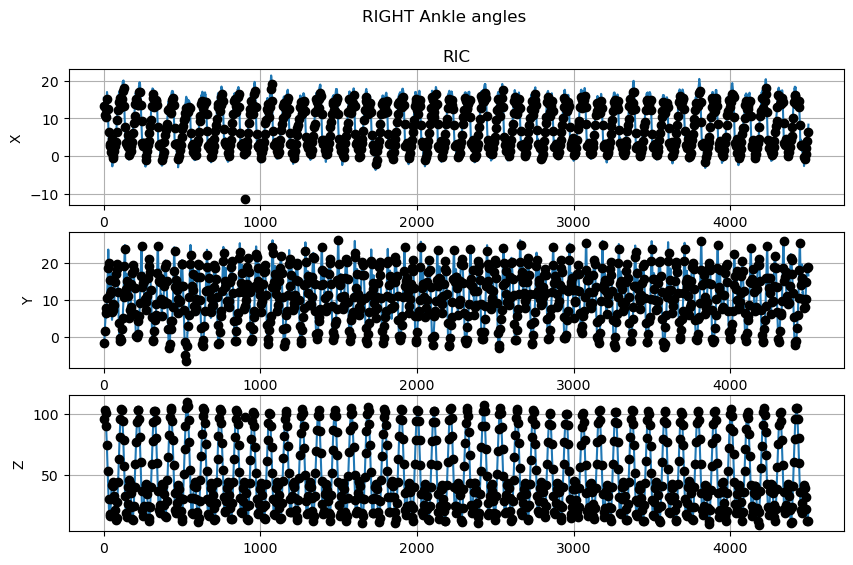

In [53]:
# RIC dataset
fig, axs = plt.subplots(3,1, figsize=(10,6))
fig.suptitle('RIGHT Ankle angles')
# RIC
axs[0].plot(method1[:,0])
axs[0].plot(tn[0::5], method2[0::5,0],'ko')
axs[0].set_ylabel('X')
axs[0].grid('on')
axs[0].set_title('RIC')
axs[1].plot(method1[:,1])
axs[1].plot(tn[0::5], method2[0::5,1],'ko')
axs[1].set_ylabel('Y')
axs[1].grid('on')
axs[2].plot(method1[:,2])
axs[2].plot(tn[0::5], method2[0::5,2],'ko')
axs[2].set_ylabel('Z')
axs[2].grid('on')
plt.show()

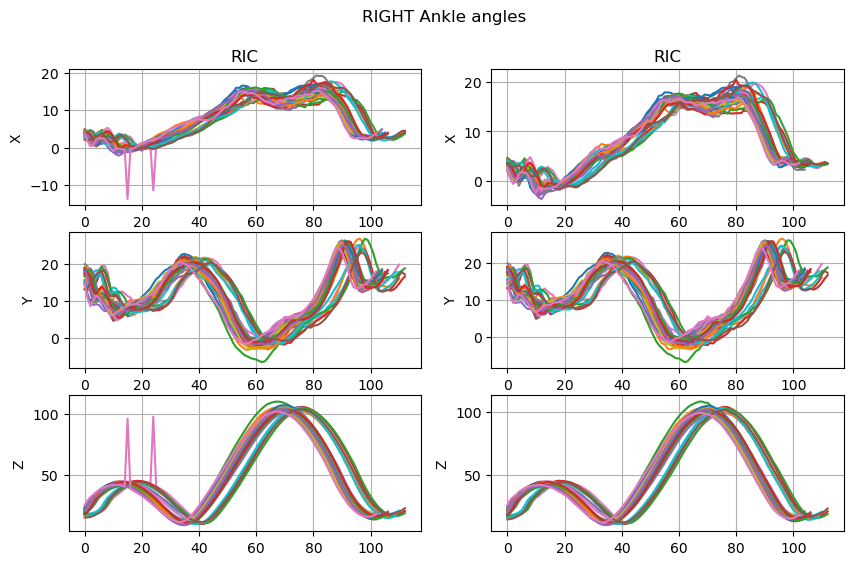

In [54]:
# RIC dataset
fig, axs = plt.subplots(3,2, figsize=(10,6))
fig.suptitle('RIGHT Ankle angles')
# RIC
for i in range(len(RTD_RIC)-1):
    axs[0,0].plot(method2[RTD_RIC[i]:RTD_RIC[i+1],0])
    axs[0,0].set_ylabel('X')
    axs[0,0].grid('on')
    axs[0,0].set_title('RIC')
    axs[1,0].plot(method2[RTD_RIC[i]:RTD_RIC[i+1],1])
    axs[1,0].set_ylabel('Y')
    axs[1,0].grid('on')
    axs[2,0].plot(method2[RTD_RIC[i]:RTD_RIC[i+1],2])
    axs[2,0].set_ylabel('Z')
    axs[2,0].grid('on')
    
    axs[0,1].plot(method1[RTD_RIC[i]:RTD_RIC[i+1],0])
    axs[0,1].set_ylabel('X')
    axs[0,1].grid('on')
    axs[0,1].set_title('RIC')
    axs[1,1].plot(method1[RTD_RIC[i]:RTD_RIC[i+1],1])
    axs[1,1].set_ylabel('Y')
    axs[1,1].grid('on')
    axs[2,1].plot(method1[RTD_RIC[i]:RTD_RIC[i+1],2])
    axs[2,1].set_ylabel('Z')
    axs[2,1].grid('on')
plt.show()